# The Monkey and the Coconuts: An Introduction to the Extended Euclidean Algorithm

## Introduction

Here is a nifty puzzle from Martin Gardner, *The Colossal Book of Mathematics*, Norton; First Edition (January 1, 2001), Chapter 1, pp. 3-9.

> In the October 9, 1926, issue of *The Saturday Evening Post* appeared a short story by Ben Ames Williams entitled "Coconuts." The story concerned a building contractor who was anxious to prevent a competitor from getting an important contract. A shrewd employee of the contractor, knowing the competitor's passion for recreational mathematics, presented him with a problem so exasperating that while he was preoccupied with solving it he forgot to enter his bid before the deadline.
> Hers is the problem exactly as the clerk in William's story phrased it:
>
> <img src="coconuts.png" height=500>
>
> Williams neglected to include the answer in his story. It is said that the offices of *The Saturday Evening Post* were showered with some 2,000 letters during the first week after the issue appeared. George Horace Lorimer, then editior-in-chief, sent Williams the following history wire: 
>
> > FOR THE LOVE OF MIKE, HOW MANY COCONUTS? HELL POPPING AROUND HERE.
> 
> For 20 years Williams continued to receive letters requesting the answer or proposing new solutions.


Notice this puzzle is very much like some earlier Diophantine equation puzzles:

  * [100 Bushels of Corn](https://ninazumel.com/blog/2024-09-26-100bushels/)
  * [The Wine Thief Problem](https://ninazumel.com/blog/2024-10-10-wine-thief/)
  * [Dudeney’s Remainder Problem](https://win-vector.com/2024/10/06/dudeneys-remainder-problem/)
  * [Dudeney’s Catching The Mice Puzzle](https://win-vector.com/2024/10/11/dudeneys-catching-the-mice-puzzle/)

The telling even includes the now traditional "publishers and solvers suffering" detail!

This style of over-story gets itself later attached to the famous "12 coins problem." From [Richard K. Guy and Richard J. Nowakowski "Coin-Weighing Problems", The American Mathematical Monthly, Feb., 1995, Vol. 102, No. 2 (Feb., 1995), pp. 164-167](https://www.jstor.org/stable/2975353).

> The problem was popular on both sides of the Atlantic during World War II ...; it was even suggested that it should be dropped over Germany in an attempt to sabotage their war effort ... .

For some fun approaches to the 12 coins problem please see:

  * [The Twelve Coins Puzzle](https://ninazumel.com/blog/2024-10-17-twelve-coins/)
  * [Dyson’s Algorithm for the Twelve Coins Problem](https://ninazumel.com/blog/2024-10-23-dysons-algorithm/)

## What Makes for a Great Puzzle

In my mind one thing that makes for a great puzzle is: you feel (rightly or wrongly) you used or invented a systematic technique to solve it. The Monkey and the Coconuts is great as it is solvable by at least two powerful systematic techniques:

  * Brute force search
  * Diophantine equations

The puzzle is also solvable by careful accounting of algorithm state, but we don't dig into that solution family.

This is part of our informal series trying to build a back and forth puzzles to algorithms and algorithms to puzzles theory.

## Solving by Inspection or Brute Force

A good current way to solve The Monkey and the Coconuts Problem [Wikipedia ref](https://en.wikipedia.org/wiki/The_monkey_and_the_coconuts) is: define an inspector that determines if we have a correct solution and just search for a correct solution. This looks like the following.



In [1]:
def run_solution(x: int, *, verbose: bool = False) -> bool:
    if verbose:
        print(f'start with {x} coconuts')
    for step in range(0, 5):
        if (x-1) % 5 != 0:  # coconuts must be divisible by 5 after Monkey gets one
            return False
        take = (x - 1) // 5
        x = (x - 1) - take
        if verbose:
            print(f"man {step} takes {take} coconuts for self, 1 for monkey, leaving {x}")
    if x % 5 != 0: # remaining coconuts must be divisible by 5
        return False
    if verbose:
        print(f"next day: each share is {x // 5} with no more for the monkey")
    return True

Now we can find a solution.

In [2]:
soln_williams_search = 0
while not run_solution(soln_williams_search, verbose=False):
    soln_williams_search += 1

soln_williams_search

3121

In [3]:
assert run_solution(soln_williams_search, verbose=True) == True

start with 3121 coconuts
man 0 takes 624 coconuts for self, 1 for monkey, leaving 2496
man 1 takes 499 coconuts for self, 1 for monkey, leaving 1996
man 2 takes 399 coconuts for self, 1 for monkey, leaving 1596
man 3 takes 319 coconuts for self, 1 for monkey, leaving 1276
man 4 takes 255 coconuts for self, 1 for monkey, leaving 1020
next day: each share is 204 with no more for the monkey


Our claim is now: `3121` coconuts is a solution (and a smallest non-negative solution). It seems to be common for these puzzles to have solutions that are way out of "reasonable range", as with `3121` coconuts around we don't expect so much pilfering and hording would be required.

This sort of solution style may seem trivial, but that is in fact the great power of the method. We build a predicate <code>is_valid_solution(n)</code> which tells if a proposal is a valid solution or not. The we compute <code>is_valid_solution<sup>-1</sup>(True)</code> by search.

This is why in the 1950s through 1980s search was marketed as an AI product. The first "AI" to beat a world chess champion, "[Deep Blue](https://en.wikipedia.org/wiki/Deep_Blue_(chess_computer))", was just a high-speed search tool. This is also the crux of the "[P versus NP problem](https://en.wikipedia.org/wiki/P_versus_NP_problem)": if one has a predicate (function that returns True or False) that is easy to compute, is it also easy to find an input that returns the value "True"?

With computers it is trivial to implement many functions, could it be the case many of them could also be systematically inverted? We honestly do not know.

## Non Brute Force Methods

Let's try to use some math to solve this in a more "pencil and paper" style. We use `sympy` to capture simultaneous equations describing how many coconuts are in the pile at each stage of the game. 

In [4]:
import inspect
import numpy as np
import pandas as pd
import sympy as sp
from IPython.display import display, Markdown
from gcd_table import build_gcd_table, back_fill_gcd_table
from convert_table_to_image import display_styled_table

We start with `n` coconuts and proceed to piles of size `a` through `f` as the thefts happen and the final division is made.

In [5]:
n, a, b, c, d, e, f = sp.symbols('n, a, b, c, d, e, f')

The telling of the story is that the following equations hold for non-negative integer values of all of our variables. In `sympy` a formula of the form `n - (5 * a + 1)` is shorthand for `n - (5 * a + 1) == 0`. So we capture our required equations as the following expressions.

In [6]:
eqns_williams = [
        n - (5 * a + 1),
    4 * a - (5 * b + 1),
    4 * b - (5 * c + 1),
    4 * c - (5 * d + 1),
    4 * d - (5 * e + 1),
    4 * e - (5 * f),
]

eqns_williams

[-5*a + n - 1,
 4*a - 5*b - 1,
 4*b - 5*c - 1,
 4*c - 5*d - 1,
 4*d - 5*e - 1,
 4*e - 5*f]

 If we guess non-negative integers `a, b, c, d , e, f, n` such that all lof these expressions are zero, we have a solution. Of course that is wasteful- all of the other values are determined if we guess `n`.

Let's eliminate all variables except `n`, the original number of coconuts. 



In [7]:
solns_williams = sp.solve(
    eqns_williams, 
    [a, b, c, d, e, f]
)
solns_williams = {
    k: v.together() for k, v in solns_williams.items()}

solns_williams

{a: (n - 1)/5,
 b: (4*n - 9)/25,
 c: (16*n - 61)/125,
 d: (64*n - 369)/625,
 e: (256*n - 2101)/3125,
 f: 4*(256*n - 2101)/15625}

A valid solution must have all of these expressions simultaneously be non-negative integers. This means the numerators must be evenly divisible by the denominators. 

To use this in the solution we will work ["modulo"](https://en.wikipedia.org/wiki/Modular_arithmetic) the denominators. Working "modulo k" means we work over equivalence classes where the integers `a` and `a+k` are considered the same (though we will often use the unique representative integer in the half open interval [0, k) as a preferred or canonical example). We will exploit that addition and multiplication "modulo k" often looks looks a lot like regular *rational* arithmetic. That is, we have the commutative law and often *multiplicative* inverses (which is not true in general for the original integers). We will also use that when working "modulo k" we can often insert yet another "remainder by k" without changing the actual answer.

 As a first try let's try to see if we can satisfy the last expression (`f`) and see if the other follow. The `f` expression is as follows.



In [8]:
solns_williams[f]

4*(256*n - 2101)/15625

For solutions, the above expression must be a non-negative integer. This implies `15625` divides evenly into `256 n - 2101`.

This implies that <code>256 * n &Congruent; 2101 mod 15625</code>. This relation will be true for any solution to the original problem.

It turns out finding the smallest non-negative solution to this in fact solves the whole original problem.

But how do we solve even this new relation? Suppose there was an integer <code>inv_256</code> such that <code>inv_256 &Congruent; 256<sup>-1</sup> mod 15625</code>. Then we would have <code>n &Congruent; inv_256 * 2101 mod 15625</code> is our solution <code>n</code>.

Suppose for a moment <code>inv_256</code> exists and we know its value. Let's confirm that finishes the problem solution. 

In [9]:
# magic guess at multiplicative inverse of 256 mod 15625
inv_256 = 12146

inv_256

12146

In [10]:
# confirm it works
assert (256 * inv_256) % 15625 == 1
assert (inv_256 * 256) % 15625 == 1

(256 * inv_256) % 15625

1

In [11]:
# use it to solve the puzzle
soln_williams_math = (inv_256 * 2101) % 15625
assert soln_williams_math == soln_williams_search

soln_williams_math 

3121

Of course, we still need to show how we found `inv_256 = 12146`.

## Where we found `inv_256`

The question remains: where did we find this magic `inv_256`?

We can set this up as the equation in two integer unknowns (`u`, `inv_256`):

`u * 15625 + inv_256 * 256 = 1`.

The above equation is a way of saying <code>inv_256 * 256 &Congruent; mod 15625</code>. And we can solve this simultaneous equation using the so-called "[extended Euclidean algorithm](https://en.wikipedia.org/wiki/Extended_Euclidean_algorithm)". This is where the trick of the puzzle lies. The basic [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm) may have been part of standard mathematical education in the early 20th century. However the *extended Euclidean algorithm* was possibly a specialist topic, and not taught.

To make the calculations shorter we will solve:

`u * 15625 + inv_2 * 2 = 1`

and then use 

`inv_256 = (inv_2**8 % 15625)`.

### A special case algebraic solution

The general way to solve the above problem is the extended greatest common divisor algorithm, which we will explain in the next section. However we have a special case as `15625` is odd and we want `inv_2 mod 15625`. Just guess that `u = 1` in `u * 15625 + inv_2 * 2 = 1` and then we have `inv_2 = (1 - 15625) / 2` which is an integer. However there is systematic way for dealing with arbitrary integers, which we will outline below.


### The Extended GCD solution

The extended Euclidean algorithm can be realized as the following table calculation. The basic Euclidean algorithm is a tool to find the [greatest common divisor](https://en.wikipedia.org/wiki/Greatest_common_divisor) (GCD) of two non-negative integers. It does this by using the reduction `GCD(a, b) = GCD(b, a % b)` when `a >= b > 0`. Using this idea we build a table of equivalent smaller and smaller GCD problems as follows.

In [12]:
display(Markdown(f"```python\n{inspect.getsource(build_gcd_table)}\n```"))

```python
def build_gcd_table(a: int, b: int, 
    *, 
    verbose: bool = False) -> pd.DataFrame:
    """
    :param a: positive int
    :param b: non-negative int with b < a
    :return: extended GCD work table (not backfilled, see back_fill_gcd_table())
    Note: may swap a, b to establish entry invariant.
    """
    a, b = int(np.abs(a)), int(np.abs(b))
    if b > a:
        a, b = b, a
    assert (a >= b) and (b >= 0)
    row_count_hint = None
    if verbose:
        row_count_hint = build_gcd_table(a, b, verbose=False).shape[0]
    captured_tables = []
    result = []
    while (b > 0) and (a > b):
        q = a // b  # quotient
        r = a - b * q  # remainder
        row = pd.DataFrame({"a": [a], "b": [b], "a%b": [r], "a//b": [q], "GCD(a, b)": None})
        result.append(row)
        _display_intermediate_forward_table(
            result, do_display=verbose, row_count_hint=row_count_hint, captured_tables=captured_tables)
        # prepare for next step using gcd(a, b) = gcd(b, r)
        a, b = b, r
    row = pd.DataFrame({"a": [a], "b": [b], "a%b": ["N/A"], "a//b": ["N/A"], "GCD(a, b)": None})
    result.append(row)
    gcd_table = pd.concat(result, ignore_index=True)
    gcd_table["GCD(a, b)"] = a
    _display_final_forward_table(gcd_table, do_display=verbose, captured_tables=captured_tables)
    gcd_table.attrs['captured_tables'] = captured_tables
    return gcd_table

```

This first part is just the standard basic Euclidean algorithm with verbose table bookkeeping. In particular we don't normally store the quotient, but we are saving it for later use. Let's see the calculation in action. We iteratively build up our table as follows (a person would be extending a single table, not writing out multiple tables). Think of each row as being keyed by the first two columns, and notice these columns are formed by copy the second and third column from the previous row. New values are shown with a yellow background, and values used as inputs are shown with a green background.

'build row 0: start (a >= b)'

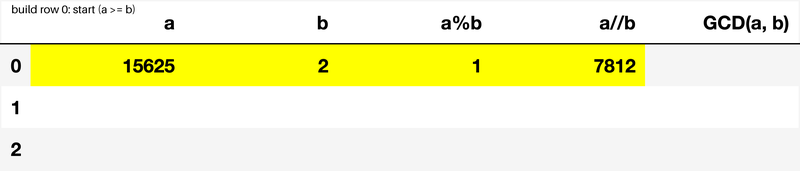

'build row 1: a[1]=b[0], b[1]=(a%b)[0]'

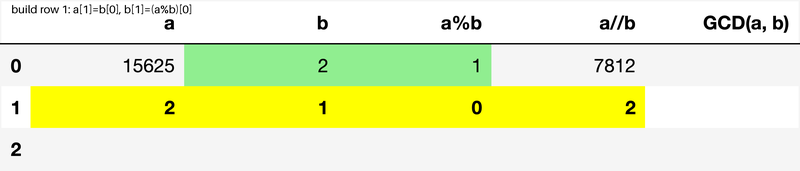

'finish with row 2: a[2]=b[1], b[2]=(a%b)[1], GCD= a[2]'

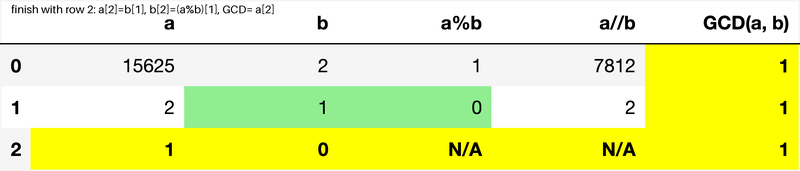

In [13]:
gcd_table = build_gcd_table(15625, 2, verbose=True)

n_fwd_tables = len(gcd_table.attrs['captured_tables'])
for st in gcd_table.attrs['captured_tables']:
    display(st.data.attrs['note'])
    display_styled_table(st)


The theory of the basic Euclidean algorithm implies: all the rows have the same `GCD(a,b)`.  As we know the GCD of the last row we therefore know the GCD of all the rows. In particular we know the GCD of the first row: the equation we were trying to solve as a sub-step to our puzzle solution. Building a table like the above goes back to antiquity.

The quantity we want is `inv_256 = gcd_table.loc[0, 'v']`. Unfortunately this is not yet filled-in.

For each row the *extended* Euclidean algorithm theory says for each row we can find integers `u`, `v` such that `a * u + b * v = GCD(a, b)`. For the very last row we have `a = GCD(a, b)`, therefor `u=1, v=0` is a working solution.

We show in an appendix this is enough to demonstrate:

 * `u[i] = v[i+1]`
 * `v[i] = u[i+1] - (a[i]//b[i]) * v[i+1]`

This in turn lets us back-fill the table as follows.

In [14]:
display(Markdown(f"```python\n{inspect.getsource(back_fill_gcd_table)}\n```"))

```python
def back_fill_gcd_table(result: pd.DataFrame, *, verbose: bool = False) -> None:
    """
    Back fill u, v into extended GCD table.
    See: build_gcd_table(), build_gcd_table_filled().
    """
    result["u"] = None
    result.loc[result.shape[0] - 1, "u"] = 1
    result["v"] = None
    result.loc[result.shape[0] - 1, "v"] = 0
    try:
        captured_tables = result.attrs['captured_tables']
    except KeyError:
        captured_tables = None
    _display_backfill_step(
        result, i=result.shape[0] - 1, do_display=verbose, captured_tables=captured_tables)
    for i in reversed(range(result.shape[0] - 1)):
        result.loc[i, "u"] = result.loc[i + 1, "v"]
        result.loc[i, "v"] = (result.loc[i + 1, "u"] 
                              - result.loc[i, "a//b"] * result.loc[i + 1, "v"])
        _display_backfill_step(result, i=i, do_display=verbose, captured_tables=captured_tables)
    assert np.all(result["u"] * result["a"] + result["v"] * result["b"] == result["GCD(a, b)"])

```

'back fill row 2: u[2]=1, v[2]=0'

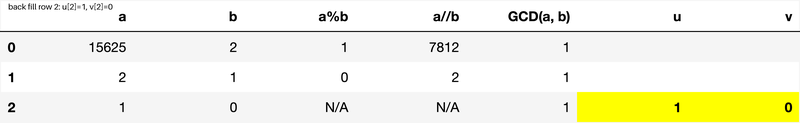

'back fill row 1: u[1]=v[2], v[1] = u[2] - (a//b)[1] * v[2]'

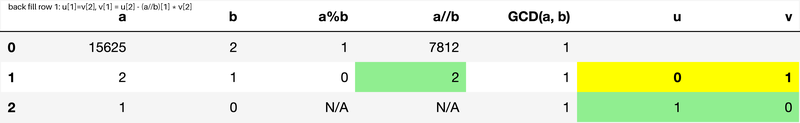

'back fill row 0: u[0]=v[1], v[0] = u[1] - (a//b)[0] * v[1]'

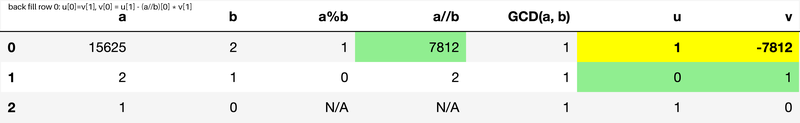

In [15]:
back_fill_gcd_table(gcd_table, verbose=True)

for i, st in enumerate(gcd_table.attrs['captured_tables']):
    if i >= n_fwd_tables:
        display(st.data.attrs['note'])
        display_styled_table(st)

We confirm the desired relation `a * u + b * v = GCD(a, b)` holds throughout. 

In [16]:

assert np.all(gcd_table['u'] * gcd_table['a'] + gcd_table['v'] * gcd_table['b'] == gcd_table['GCD(a, b)'])

An animated fill out of the above tables can be found [here](https://youtu.be/U-OJXpjxo-c). Discussion of a more compact notation for such solution tables can be found here: [Calculating at Pencil and Paper Scale](https://win-vector.com/2024/11/06/calculating-at-pencil-and-paper-scale/).

All of this would not be too bad using pencil and paper. A human would not need to follow the exact steps of `build_gcd_table()`, but instead fill out the table in an down pass followed by an up pass. That is to say: the algorithm is a bit overly detailed as it has to specify how the table is laid out and realized.

The value we want is `gcd_table.loc[0, 'v'] % 15625`:

In [17]:
inv_2 = gcd_table.loc[0, 'v'] % 15625
# confirm desired properties
assert (inv_2 * 2) % 15625 == 1
assert (2 * inv_2) % 15625 == 1

inv_2

7813

We confirm `(inv_2 ** 8) % 15625` is indeed our magic `inv_256` solution. We use the relation `(a * b) % c = ((a % c) * (b % c)) % c` to work with smaller integers.

In [18]:
# form inv_256 from inv_2
math_inv_256 = 1
for i in range(8):
    math_inv_256 = (math_inv_256 * inv_2) % 15625

In [19]:
# check that it matches our magic value
assert math_inv_256 == inv_256

And this was the magic number needed to build the coconut puzzle solution.

## A variation

Gardner states there is an older version of the puzzle where the Monkey gets a coconut even in the final division. This can be solved using the tools we already have.

In [20]:
eqns_older = [
        n - (5 * a + 1),
    4 * a - (5 * b + 1),
    4 * b - (5 * c + 1),
    4 * c - (5 * d + 1),
    4 * d - (5 * e + 1),
    4 * e - (5 * f + 1),
]

eqns_older

[-5*a + n - 1,
 4*a - 5*b - 1,
 4*b - 5*c - 1,
 4*c - 5*d - 1,
 4*d - 5*e - 1,
 4*e - 5*f - 1]

In [21]:
solns_older = sp.solve(
    eqns_older, 
    [a, b, c, d, e, f]
)
solns_older = {
    k: v.together() for k, v in solns_older.items()}

solns_older

{a: (n - 1)/5,
 b: (4*n - 9)/25,
 c: (16*n - 61)/125,
 d: (64*n - 369)/625,
 e: (256*n - 2101)/3125,
 f: (1024*n - 11529)/15625}

In this case our solution is `(inv_1024 * 11529) % 15625` where `inv_1024 = inv_2**10 % 15625`.

In [22]:
# form inv_1024 from inv_2
math_inv_1024 = 1
for i in range(10):
    math_inv_1024 = (math_inv_1024 * inv_2) % 15625

In [23]:
soln_older = (math_inv_1024 * 11529) % 15625

soln_older

15621

In [24]:
# check equations
{k: s.subs(n, soln_older) for k, s in solns_older.items()}

{a: 3124, b: 2499, c: 1999, d: 1599, e: 1279, f: 1023}

In [25]:
# check procedure
x = soln_older
print(f'start with {x} coconuts')
for step in range(0, 5):
    assert (x-1) % 5 == 0
    take = int((x - 1) / 5)
    x = (x - 1) - take
    print(f"man {step} takes {take} coconuts for self, 1 for monkey, leaving {x}")
assert (x-1) % 5 == 0
print(f"next day: each share is {int((x-1)/5)} with 1 more for the monkey")

start with 15621 coconuts
man 0 takes 3124 coconuts for self, 1 for monkey, leaving 12496
man 1 takes 2499 coconuts for self, 1 for monkey, leaving 9996
man 2 takes 1999 coconuts for self, 1 for monkey, leaving 7996
man 3 takes 1599 coconuts for self, 1 for monkey, leaving 6396
man 4 takes 1279 coconuts for self, 1 for monkey, leaving 5116
next day: each share is 1023 with 1 more for the monkey


All the equations are satisfied, and the check algorithm confirms this is a solution.

## Gardner's solution

Gardner spends a lot of time working through different ways to solve the problem, while avoiding needing the magic `inv_2`. Garnder knows this solution method, and even knows of a continued fraction tool to handle the intermediate record keeping we showed in our tabular extended Euclidean algorithm method. Likely Gardner doesn't think this is the easiest solution to bring to his readers. He is likely right. In this note we concentrated more what was easy for us (with our background and access to `sympy`) than what would require the least reference material.


## Dirac's Solution

Miodrag S. Petković, *Famous Puzzles of Great Mathematicians*, AMS, 2009 has a great section on this problem. This includes a fun description of Paul Dirac quickly working out `-4` satisfies the older puzzle equations.


In [26]:
# check equations
{k: s.subs(n, -4) for k, s in solns_older.items()}

{a: -1, b: -1, c: -1, d: -1, e: -1, f: -1}

Then presenting the solution `15621` which is equivalent to `-4` mod `15625` (the common denominator or modulus of all the check equations). This may be some meta-reasoning on Dirac's part: assuming the puzzle was designed to amenable to search, and then exploiting that assumption. Likely the later variation problem was designed to eliminate this sort of solution by moving the solution to be simultaneously far away from `0` and `15625`.

## Conclusion

The monkey and the coconuts problem is a "dead center" example of a [Diophantine equation](https://en.wikipedia.org/wiki/Diophantine_equation) problem. So the methods shown are indeed the right way to solve it. I am hoping delegating the algebra to `sympy` makes this more readable in our programming oriented era.


## Appendices

### Appendix: Solving the Back-Fill Equations


Here we derive the back-fill equations that let us derive `u[i]` and `v[i]` from later rows.

We start with the following:

  * `u[i] a[i] = v[i] b[i] = GCD`
  * `u[i+1] a[i+1] = v[i+1] b[i+1] = GCD`. 
  
Inspecting the forward GCD table code gives us:

  * `a[i+1] = b[i]`
  * `b[i+1] = a[i] - (a[i]//b[i]) b[i]`. 
  
This is enough to solve for `u[i]` and `v[i]` as follows. The following equation must be true for *all* `a[i]` and `b[i]`.

In [27]:
a_i, b_i, u_i, v_i, a_ip1, b_ip1, u_ip1, v_ip1, GCD, q = sp.symbols('a_{i} b_{i} u_{i} v_{i} a_{i+1} b_{i+1} u_{i+1} v_{i+1} GCD (a_{i}//b_{i})')

eqn = u_i * a_i + v_i * b_i - GCD  # relation in row i
eqn = eqn.subs({GCD: u_ip1 * a_ip1 + v_ip1 * b_ip1})  # use row i+1 to eliminate GCD variable
eqn = eqn.subs({a_ip1: b_i, b_ip1: a_i - q * b_i}).expand() # this expression should equal zero for ALL a_i, b_i

eqn

(a_{i}//b_{i})*b_{i}*v_{i+1} + a_{i}*u_{i} - a_{i}*v_{i+1} - b_{i}*u_{i+1} + b_{i}*v_{i}

This means we can choose substitutions of values for `a[i]` and `b[i]` to solve. We choose values such that each resulting expression has only one of `u[i]` or `v[i]`.

In [28]:
# so we can solve by substituting in a_i, b_i
# so that each expression has only one of u_i, v_i
{
    u_i: sp.solve(eqn.subs({a_i: 1, b_i: 0}), u_i)[0],
    v_i: sp.solve(eqn.subs({a_i: 0, b_i: 1}), v_i)[0],
}

{u_{i}: v_{i+1}, v_{i}: -(a_{i}//b_{i})*v_{i+1} + u_{i+1}}

This completes the claim:

 * `u[i] = v[i+1]`
 * `v[i] = u[i+1] - (a[i]//b[i]) * v[i+1]`

The above being a the backwards fill steps for the extended Euclidean algorithm.

### Appendix: A Nice Matrix Solution

A nice matrix bookkeeping solution to the extended-GCD sub-problem (in R) is as follows. This time we do all of the bookkeeping in a single matrix. This uses the usual linear algebra trick of tracking operations by multiplying starting at a set of columns representing a copy of the identity matrix. Here is such a solution to the extended GCD problem in R:

<pre><code>
extended_gcd &lt;- function(a, b) {
  "
  For non-negative integers a, b (a &gt; 0, a &gt;= b)
  return (gcd, u, v) such that u * a + v * b = gcd, and gcd is greatest common divisor of a, b.
  "
  stopifnot(a &gt;= b)
  stopifnot(a &gt; 0)
  stopifnot(b &gt;= 0)
  
  a_mat &lt;- matrix(c(
    a, 1, 0,
    b, 0, 1),
    nrow = 2, ncol = 3, byrow = TRUE)
  
  while(a_mat[2, 1] != 0) {
    p &lt;- matrix(c(
      0, 1,
      1, - floor(a_mat[1, 1] / a_mat[2, 1])),
      nrow = 2, ncol = 2, byrow = TRUE)
    a_mat &lt;- p %*% a_mat
  }
  
  gcd_value &lt;- a_mat[1, 1]
  u &lt;- a_mat[1, 2]
  v &lt;- a_mat[1, 3]
  
  stopifnot(gcd_value == u * a + v * b)
  return(list(gcd = gcd_value, u = u, v = v))
}
</code></pre>